In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,InputLayer,AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import BatchNormalization,Dropout,Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionV3, ResNet50,MobileNetV2, VGG19, EfficientNetB7, EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from keras.mixed_precision import set_global_policy
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet_v2 import preprocess_input
import pickle

In [3]:
df = pd.read_csv('more_dataset.csv')
df

,Unnamed: 0,img_path,label
0,0,D:/Github/Datasets/combined_indian_dataset\dou...,double_ka_meetha
1,1,D:/Github/Datasets/combined_indian_dataset\ome...,omelette
2,2,D:/Github/Datasets/combined_indian_dataset\kof...,kofta
3,3,D:/Github/Datasets/combined_indian_dataset\ghe...,ghevar
4,4,D:/Github/Datasets/combined_indian_dataset\poh...,poha
...,...,...,...
7526,7526,D:/Github/Datasets/combined_indian_dataset\kac...,kachori
7527,7527,D:/Github/Datasets/combined_indian_dataset\bha...,bhatura
7528,7528,D:/Github/Datasets/combined_indian_dataset\ana...,anarsa
7529,7529,D:/Github/Datasets/combined_indian_dataset\adh...,adhirasam


In [9]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class ImageDataPipeline:
    def __init__(self, csv_path, image_size=224, batch_size=32):
        self.csv_path = csv_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.label_encoder = LabelEncoder()
        
    def load_data(self):
        """
        Load and prepare the dataset from CSV
        """
        # Read CSV file
        df = pd.read_csv(self.csv_path)
        
        # Encode labels
        self.label_encoder.fit(df['label'])
        encoded_labels = self.label_encoder.transform(df['label'])
        
        # Convert to one-hot encoding
        num_classes = len(self.label_encoder.classes_)
        one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes)
        
        # Split dataset
        train_df, val_df, train_labels, val_labels = train_test_split(
            df['img_path'],
            one_hot_labels,
            test_size=0.2,
            stratify=encoded_labels,  # Ensure balanced split
            random_state=42
        )
        
        return train_df, val_df, train_labels, val_labels, num_classes
    
    def _parse_image(self, image_path):
        """
        Load and preprocess a single image
        """
        # Read image file
        img = tf.io.read_file(image_path)
        # Decode image
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        # Convert to float32 and normalize
        img = tf.cast(img, tf.float32) / 255.0
        # Resize image
        img = tf.image.resize(img, [self.image_size, self.image_size])
        return img
    
    def create_dataset(self, image_paths, labels, is_training=True):
        """
        Create a tf.data.Dataset pipeline
        """
        # Create dataset from tensors
        ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        
        # Parse images
        ds = ds.map(
            lambda x, y: (self._parse_image(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if is_training:
            # Cache the dataset
            ds = ds.cache()
            
            # Shuffle, batch, and prefetch
            ds = ds.shuffle(buffer_size=1000)
            ds = ds.batch(self.batch_size)
            ds = ds.prefetch(tf.data.AUTOTUNE)
        else:
            # For validation, we don't need shuffling
            ds = ds.batch(self.batch_size)
            ds = ds.prefetch(tf.data.AUTOTUNE)
        
        return ds

def prepare_datasets(csv_path, image_size=224, batch_size=32):
    """
    Prepare train and validation datasets from CSV
    """
    # Initialize pipeline
    pipeline = ImageDataPipeline(csv_path, image_size, batch_size)
    
    # Load and split data
    train_paths, val_paths, train_labels, val_labels, num_classes = pipeline.load_data()
    
    # Create datasets
    train_ds = pipeline.create_dataset(train_paths, train_labels, is_training=True)
    val_ds = pipeline.create_dataset(val_paths, val_labels, is_training=False)
    
    return train_ds, val_ds, num_classes, pipeline.label_encoder

In [4]:
def build_model_optimized(base):
    """
    Enhanced version with Adam optimizer and weight decay
    """
    set_global_policy('mixed_float16')

    base_model = base
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    
    # Global pooling with additional channel attention
    gap = GlobalAveragePooling2D()(x)
    gmp = GlobalMaxPooling2D()(x)
    pooled = keras.layers.Concatenate()([gap, gmp])
    
    # First dense block (512) with residual connection
    x1 = Dense(512, kernel_initializer='he_normal',
               kernel_regularizer=keras.regularizers.l2(1e-5))(pooled)
    x1 = BatchNormalization(momentum=0.9)(x1)
    x1 = Activation('relu')(x1)
    x1 = Dropout(0.3)(x1)
    
    # Second dense block (256) with skip connection
    x2 = Dense(256, kernel_initializer='he_normal',
               kernel_regularizer=keras.regularizers.l2(1e-5))(x1)
    x2 = BatchNormalization(momentum=0.9)(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(0.3)(x2)
    
    # Third dense block (128) with skip connection
    x3 = Dense(128, kernel_initializer='he_normal',
               kernel_regularizer=keras.regularizers.l2(1e-5))(x2)
    x3 = BatchNormalization(momentum=0.9)(x3)
    x3 = Activation('relu')(x3)
    x3 = Dropout(0.3)(x3)
    
    # Residual connections
    res1 = Dense(256, kernel_regularizer=keras.regularizers.l2(1e-5))(pooled)
    res2 = Dense(128, kernel_regularizer=keras.regularizers.l2(1e-5))(x1)
    
    # Combine features with skip connections
    x = keras.layers.Add()([x2, res1])
    x = keras.layers.Add()([x3, res2])
    x = keras.layers.Concatenate()([x, x3])
    
    # Final classification layer
    outputs = Dense(73, activation='softmax',
                   kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    
    model = keras.Model(inputs, outputs)
    
    # Compile with Adam and learning rate schedule
    initial_learning_rate = 1e-3
    
    # Define learning rate schedule
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate,
        decay_steps=100 * 1000,  # adjust based on your dataset size
        alpha=1e-5  # minimum learning rate
    )
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=lr_schedule,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        ),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    return model

In [5]:
def train_with_advanced_fine_tuning(model, train_data, val_data, batch_size=16):
    """
    Enhanced training pipeline with:
    - Progressive learning rate adjustment
    - Gradual unfreezing
    - Cosine annealing
    - Modified Adam optimizer configuration
    """
    import numpy as np
    from tensorflow import keras
    from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
    
    # Adjusted learning rates for Adam optimizer
    initial_learning_rate = 5e-4  # Reduced from 1e-3 for Adam
    warmup_epochs = 5
    total_epochs = 40
    
    def warmup_cosine_decay_schedule(epoch):
        if epoch < warmup_epochs:
            return initial_learning_rate * (epoch + 1) / warmup_epochs
        else:
            return initial_learning_rate * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    
    callbacks = [
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        LearningRateScheduler(warmup_cosine_decay_schedule),
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Slightly reduced patience
            restore_best_weights=True,
            verbose=1
        )
    ]
    
    # Phase 1: Train only the top layers
    print("Phase 1: Initial training")
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=initial_learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7  # Slightly lower epsilon for better precision
        ),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    history1 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        batch_size=batch_size,
        callbacks=callbacks
    )
    
    # Phase 2: Gradual unfreezing
    print("Phase 2: Gradual unfreezing")
    base_model = model.layers[1]
    for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
        layer.trainable = True
    
    # Recompile with lower learning rate for fine-tuning
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=1e-5,  # Lower learning rate for fine-tuning
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        ),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    
    history2 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        batch_size=batch_size,
        callbacks=callbacks
    )
    
    return model, history1, history2

In [33]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

class AdvancedAugmentation:
    def __init__(self, image_size=224, mixup_alpha=0.2, cutmix_alpha=1.0):
        self.image_size = image_size
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        
    def get_aggressive_augmentation(self):
        """
        Returns an aggressive augmentation pipeline
        """
        return tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomTranslation(0.1, 0.1),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomBrightness(0.2),
            # Color jittering
            tf.keras.layers.RandomZoom(0.2),
            # Random shear
            # tfa.layers.RandomShear(0.2),
            # Gaussian noise
            tf.keras.layers.GaussianNoise(0.1),
            # Color distortion
            tf.keras.layers.Lambda(
            lambda x: tf.image.random_saturation(x, lower=0.7, upper=1.3)),
            tf.keras.layers.Lambda(
            lambda x: tf.image.random_hue(x, max_delta=0.2)),
        ])
    seed = tf.random.get_global_generator().make_seeds()[:, 0]
    def mixup(self, images, labels):
        """
        Performs Mixup augmentation
        """
        batch_size = tf.shape(images)[0]
        alpha = self.mixup_alpha
        
        # Generate mixup weights
        weights = tf.random.stateless_beta_v2(shape=[batch_size], alpha=alpha, beta=alpha)
        x_weights = tf.reshape(weights, (batch_size, 1, 1, 1))
        y_weights = tf.reshape(weights, (batch_size, 1))
        
        # Create shuffled indices
        indices = tf.random.shuffle(tf.range(batch_size))
        
        # Mix the images
        images_shuffled = tf.gather(images, indices)
        labels_shuffled = tf.gather(labels, indices)
        
        # Perform mixup
        images_mixed = images * x_weights + images_shuffled * (1 - x_weights)
        labels_mixed = labels * y_weights + labels_shuffled * (1 - y_weights)
        
        return images_mixed, labels_mixed
    
    def cutmix(self, images, labels):
        """
        Performs CutMix augmentation
        """
        batch_size = tf.shape(images)[0]
        alpha = self.cutmix_alpha
        
        # Generate random parameters
        cut_ratio = tf.random.stateless_beta_v2(alpha=alpha, beta=alpha, shape=())
        
        # Get random box coordinates
        cut_h = tf.cast(tf.cast(self.image_size, tf.float32) * tf.math.sqrt(1 - cut_ratio), tf.int32)
        cut_w = tf.cast(tf.cast(self.image_size, tf.float32) * tf.math.sqrt(1 - cut_ratio), tf.int32)
        
        center_x = tf.random.uniform((), 0, self.image_size, dtype=tf.int32)
        center_y = tf.random.uniform((), 0, self.image_size, dtype=tf.int32)
        
        bbox_x1 = tf.clip_by_value(center_x - cut_w // 2, 0, self.image_size)
        bbox_y1 = tf.clip_by_value(center_y - cut_h // 2, 0, self.image_size)
        bbox_x2 = tf.clip_by_value(center_x + cut_w // 2, 0, self.image_size)
        bbox_y2 = tf.clip_by_value(center_y + cut_h // 2, 0, self.image_size)
        
        # Create shuffled indices
        indices = tf.random.shuffle(tf.range(batch_size))
        
        # Create mask for the box
        mask = tf.ones((batch_size, self.image_size, self.image_size, 3))
        mask_box = tf.zeros((bbox_y2 - bbox_y1, bbox_x2 - bbox_x1, 3))
        mask = tf.tensor_scatter_nd_update(
            mask,
            tf.expand_dims(tf.range(batch_size), 1),
            tf.pad(mask_box, [[bbox_y1, self.image_size - bbox_y2],
                             [bbox_x1, self.image_size - bbox_x2],
                             [0, 0]])
        )
        
        # Mix the images
        images_mixed = images * mask + tf.gather(images, indices) * (1 - mask)
        
        # Mix the labels based on the area ratio
        mix_ratio = 1 - ((bbox_x2 - bbox_x1) * (bbox_y2 - bbox_y1)) / (self.image_size * self.image_size)
        labels_mixed = labels * mix_ratio + tf.gather(labels, indices) * (1 - mix_ratio)
        
        return images_mixed, labels_mixed

def create_stratified_split(dataset, labels, val_split=0.2, seed=42):
    """
    Creates a stratified split of the dataset
    """
    from sklearn.model_selection import StratifiedKFold
    
    # Convert labels to class indices if they're one-hot encoded
    if len(labels.shape) > 1:
        label_indices = np.argmax(labels, axis=1)
    else:
        label_indices = labels
    
    # Create stratified k-fold splitter
    skf = StratifiedKFold(n_splits=int(1/val_split), shuffle=True, random_state=seed)
    
    # Get train and validation indices
    train_idx, val_idx = next(skf.split(np.zeros(len(labels)), label_indices))
    
    return train_idx, val_idx

In [5]:
class GradientAccumulationModel(tf.keras.Model):
    def __init__(self, model, accumulation_steps=4):
        super().__init__()
        self.model = model
        self.accumulation_steps = accumulation_steps
        
        # Initialize accumulator
        self.gradient_accumulator = [
            tf.Variable(tf.zeros_like(v), trainable=False)
            for v in self.model.trainable_variables
        ]
        
    def train_step(self, data):
        images, labels = data
        
        # Get the batch size
        batch_size = tf.shape(images)[0]
        
        # Split the batch into smaller chunks
        images_split = tf.split(images, self.accumulation_steps)
        labels_split = tf.split(labels, self.accumulation_steps)
        
        total_loss = 0
        total_metrics = {}
        
        for i in range(self.accumulation_steps):
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = self.model(images_split[i], training=True)
                loss = self.compiled_loss(labels_split[i], predictions)
                scaled_loss = loss / self.accumulation_steps
                
            # Compute gradients
            gradients = tape.gradient(scaled_loss, self.model.trainable_variables)
            
            # Accumulate gradients
            for acc, grad in zip(self.gradient_accumulator, gradients):
                acc.assign_add(grad)
                
            total_loss += loss
            
            # Update metrics
            self.compiled_metrics.update_state(labels_split[i], predictions)
        
        # Apply accumulated gradients
        self.optimizer.apply_gradients(
            zip(self.gradient_accumulator, self.model.trainable_variables)
        )
        
        # Reset gradient accumulator
        for accumulator in self.gradient_accumulator:
            accumulator.assign(tf.zeros_like(accumulator))
        
        # Get metrics
        metrics = {m.name: m.result() for m in self.metrics}
        metrics['loss'] = total_loss / self.accumulation_steps
        
        return metrics

def get_cosine_annealing_schedule(initial_lr, epochs):
    """
    Creates a cosine annealing learning rate schedule
    """
    def cosine_annealing(epoch):
        return initial_lr * (1 + np.cos(np.pi * epoch / epochs)) / 2
    
    return tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# Example usage:
def train_with_advanced_features(model, train_data, val_data, batch_size=32, epochs=50):
    # Create augmentation instance
    augmentation = AdvancedAugmentation()
    
    # Apply augmentations to the training data
    train_augmented = train_data.map(
        lambda x, y: (augmentation.get_aggressive_augmentation()(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply mixup/cutmix randomly
    def apply_augmix(images, labels):
        if tf.random.uniform(()) > 0.5:
            return augmentation.mixup(images, labels)
        else:
            return augmentation.cutmix(images, labels)
    
    train_augmented = train_augmented.map(
        apply_augmix,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Create gradient accumulation model
    grad_acc_model = GradientAccumulationModel(model, accumulation_steps=4)
    
    # Compile with the same settings as the original model
    grad_acc_model.compile(
        optimizer=model.optimizer,
        loss=model.loss,
        metrics=model.metrics
    )
    
    # Create callbacks
    callbacks = [
        get_cosine_annealing_schedule(initial_lr=1e-3, epochs=epochs),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )
    ]
    
    # Train the model
    history = grad_acc_model.fit(
        train_augmented,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size
    )
    
    return history

In [10]:
# Prepare base datasets
train_ds, val_ds, num_classes, label_encoder = prepare_datasets(
    csv_path='more_dataset.csv',
    image_size=224,
    batch_size=32
)

In [23]:
# Initialize augmentation
augmentation = AdvancedAugmentation(image_size=224)

# Apply augmentation to training dataset
train_ds = train_ds.map(
    lambda x, y: (augmentation.get_aggressive_augmentation()(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['img_path'], df['label'], random_state = 42, test_size = 0.2)

In [9]:
#augmention
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2, #horizontal shift
    height_shift_range=0.2, #vertical shift
    shear_range=0.2,
    zoom_range=0.2, #random zoom
    horizontal_flip=True, #random horizontal flips
    fill_mode='nearest' 
)
datagen_val = ImageDataGenerator(
    rescale=1./255 
)

In [16]:
train_ds = datagen_train.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_train,'label':y_train}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=16,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    cache=True,
    buffer_size=1000
)

test_ds = datagen_val.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_test,'label':y_test}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=16,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    cache=True,
    buffer_size=1000
)

Found 6023 validated image filenames belonging to 73 classes.
Found 1507 validated image filenames belonging to 73 classes.


d:\Anaconda\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [17]:
class_indices = train_ds.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Class Indices:
{'adhirasam': 0, 'aloo_shimla_mirch': 1, 'aloo_tikki': 2, 'anarsa': 3, 'baklava': 4, 'bandar_laddu': 5, 'basundi': 6, 'bhatura': 7, 'bhindi_masala': 8, 'biryani': 9, 'burger': 10, 'butter_chicken': 11, 'butter_naan': 12, 'chai': 13, 'chana_masala': 14, 'chapati': 15, 'chicken_razala': 16, 'chicken_tikka': 17, 'chicken_wings': 18, 'chikki': 19, 'chocolate_cake': 20, 'chocolate_mousse': 21, 'chole_bhature': 22, 'cupcakes': 23, 'dal_makhani': 24, 'dal_tadka': 25, 'donuts': 26, 'double_ka_meetha': 27, 'french_fries': 28, 'fried_rice': 29, 'gajar_ka_halwa': 30, 'garlic_bread': 31, 'gavvalu': 32, 'ghevar': 33, 'gulab_jamun': 34, 'ice_cream': 35, 'idli': 36, 'imarti': 37, 'jalebi': 38, 'kaathi_rolls': 39, 'kachori': 40, 'kajjikaya': 41, 'kakinada_khaja': 42, 'kalakand': 43, 'kofta': 44, 'kulfi': 45, 'kuzhi_paniyaram': 46, 'lassi': 47, 'lyangcha': 48, 'mac_and_cheese': 49, 'malapua': 50, 'masala_dosa': 51, 'misti_doi': 52, 'modak': 53, 'momos': 54, 'mysore_pak': 55, 'naan': 56, 

In [18]:
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = build_model_optimized(model)

In [19]:
train_with_advanced_fine_tuning(model, train_ds, test_ds, batch_size=16)

Phase 1: Initial training
Epoch 1/20
377/377 [==============================] - ETA: 0s - loss: 4.3892 - accuracy: 0.0659
Epoch 1: val_accuracy improved from -inf to 0.27737, saving model to best_model.h5
377/377 [==============================] - 309s 801ms/step - loss: 4.3892 - accuracy: 0.0659 - val_loss: 3.2323 - val_accuracy: 0.2774 - lr: 1.0000e-04
Epoch 2/20
377/377 [==============================] - ETA: 0s - loss: 3.2676 - accuracy: 0.2568
Epoch 2: val_accuracy improved from 0.27737 to 0.48374, saving model to best_model.h5
377/377 [==============================] - 145s 385ms/step - loss: 3.2676 - accuracy: 0.2568 - val_loss: 2.4638 - val_accuracy: 0.4837 - lr: 2.0000e-04
Epoch 3/20
377/377 [==============================] - ETA: 0s - loss: 2.6806 - accuracy: 0.4071
Epoch 3: val_accuracy improved from 0.48374 to 0.57598, saving model to best_model.h5
377/377 [==============================] - 151s 399ms/step - loss: 2.6806 - accuracy: 0.4071 - val_loss: 2.1592 - val_accuracy:

(<keras.engine.functional.Functional at 0x2316bae1c30>,
 <keras.callbacks.History at 0x231e2cb14b0>)

In [20]:
# finding y_pred using x_val
y_pred = []
for img_path in x_test:
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])

In [21]:
print(f"validation accuracy : {accuracy_score(y_test,y_pred)}")

validation accuracy : 0.6264100862641009


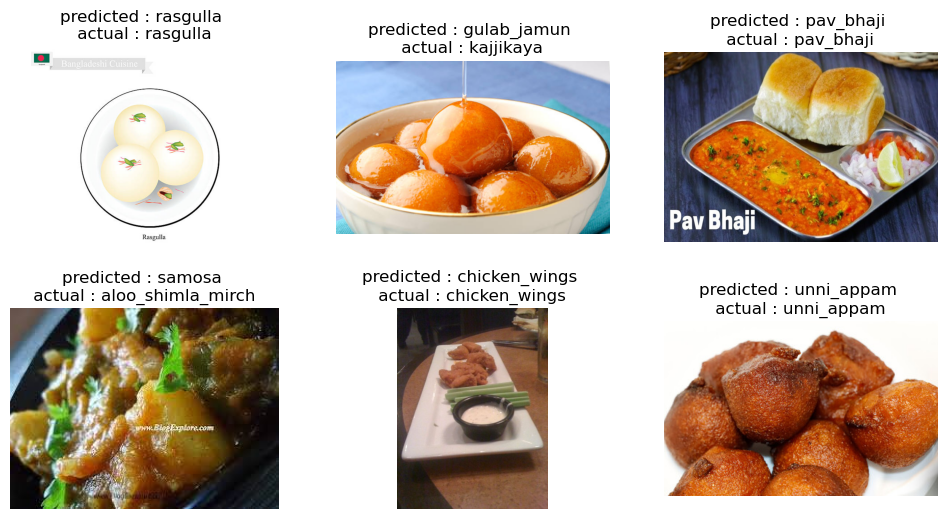

In [24]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        image = cv2.imread(x_test.values[3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(f"predicted : {y_pred[3*(i-1) + (j-1)]} \n actual : {y_test.values[3*(i-1) + (j-1)]} ")
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()